In [2]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import multiprocessing as mp

In [3]:
BTCUSDT = pd.read_parquet('kline_data/train_data/BTCUSDT.parquet', engine='fastparquet')

In [4]:
BTCUSDT['time'] = pd.to_datetime(BTCUSDT['timestamp'], unit='ms')
BTCUSDT.head(10)

,timestamp,open_price,high_price,low_price,close_price,volume,amount,count,buy_volume,buy_amount,time
0,1609430400000,28792.58,28837.77,28624.93,28676.67,2917.814,83814210.78416,23207,1071.802,30797359.96997,2020-12-31 16:00:00
1,1609431300000,28679.17,28774.78,28578.89,28671.41,2572.945,73772192.14739,19610,1186.629,34033486.64834,2020-12-31 16:15:00
2,1609432200000,28671.26,28716.06,28461.43,28509.23,2962.575,84709435.77572,19878,1045.620,29909831.81313,2020-12-31 16:30:00
3,1609433100000,28509.23,28574.60,28327.78,28408.72,4617.746,131300467.35772,29260,2274.717,64681548.08028,2020-12-31 16:45:00
4,1609434000000,28407.73,28600.99,28378.10,28599.01,3122.671,89002431.02295,22224,1814.446,51716589.79673,2020-12-31 17:00:00
5,1609434900000,28599.01,28715.64,28532.37,28660.59,2479.176,70997439.55539,19101,1264.714,36224227.98212,2020-12-31 17:15:00
6,1609435800000,28660.59,28750.00,28563.53,28730.21,1960.054,56174297.58882,15023,894.514,25643784.78662,2020-12-31 17:30:00
7,1609436700000,28730.21,28740.50,28545.73,28603.10,1630.905,46698527.94111,14034,581.664,16655815.11641,2020-12-31 17:45:00
8,1609437600000,28601.52,28698.88,28501.00,28668.00,1937.804,55436931.59454,15722,1003.415,28720628.42148,2020-12-31 18:00:00
9,1609438500000,28668.01,28785.00,28632.27,28770.00,1790.497,51442990.97746,15175,897.647,25794379.86689,2020-12-31 18:15:00


In [6]:
# Get all parquet files
parquet_dir = Path('kline_data/train_data')
parquet_files = list(parquet_dir.glob('*.parquet'))
coin_names = [f.stem for f in parquet_files]

print(f"Found {len(parquet_files)} coin files:")
for coin in sorted(coin_names):
    print(f"  {coin}")

total_size = 0
file_info = []

for file_path in parquet_files:
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    total_size += size_mb
    file_info.append((file_path.stem, size_mb))

print(f"\nFile sizes:")
for coin, size in sorted(file_info, key=lambda x: x[1], reverse=True):
    print(f"  {coin}: {size:.1f} MB")

print(f"\nTotal disk size: {total_size:.1f} MB")
print(f"Estimated RAM needed: {total_size * 2:.1f} - {total_size * 4:.1f} MB")

Found 355 coin files:
  1000000MOGUSDT
  1000BONKUSDT
  1000CATUSDT
  1000CHEEMSUSDT
  1000FLOKIUSDT
  1000LUNCUSDT
  1000PEPEUSDT
  1000RATSUSDT
  1000SATSUSDT
  1000SHIBUSDT
  1000WHYUSDT
  1000XECUSDT
  1000XUSDT
  1INCHUSDT
  1MBABYDOGEUSDT
  AAVEUSDT
  ACEUSDT
  ACHUSDT
  ACTUSDT
  ACXUSDT
  ADAUSDT
  AEROUSDT
  AEVOUSDT
  AGIXUSDT
  AGLDUSDT
  AI16ZUSDT
  AIUSDT
  AIXBTUSDT
  AKTUSDT
  ALCHUSDT
  ALGOUSDT
  ALICEUSDT
  ALPHAUSDT
  ALTUSDT
  AMBUSDT
  ANIMEUSDT
  ANKRUSDT
  APEUSDT
  API3USDT
  APTUSDT
  ARBUSDT
  ARCUSDT
  ARKMUSDT
  ARPAUSDT
  ARUSDT
  ASTRUSDT
  ATAUSDT
  ATOMUSDT
  AUCTIONUSDT
  AVAAIUSDT
  AVAUSDT
  AVAXUSDT
  AXLUSDT
  AXSUSDT
  BAKEUSDT
  BANANAUSDT
  BANDUSDT
  BANUSDT
  BATUSDT
  BBUSDT
  BCHUSDT
  BEAMXUSDT
  BELUSDT
  BICOUSDT
  BIGTIMEUSDT
  BIOUSDT
  BLURUSDT
  BLZUSDT
  BNBUSDT
  BNXUSDT
  BOMEUSDT
  BONDUSDT
  BRETTUSDT
  BSVUSDT
  BTCDOMUSDT
  BTCUSDT
  C98USDT
  CAKEUSDT
  CATIUSDT
  CELOUSDT
  CELRUSDT
  CETUSUSDT
  CFXUSDT
  CGPTUSDT
  CHILLGUYU

In [ ]:
def get_all_symbol_list(
    train_data_path: str
) -> list[str]:
    """
    Retrieves a list of currency code symbols from the training
    data directory.

    Returns:
        list: A list of currency code symbols extracted from the
        filenames in the training data directory.
    """
    parquet_name_list = os.listdir(train_data_path)
    symbol_list = [parquet_name.split(".")[0] for
                    parquet_name in parquet_name_list]
    return symbol_list

def get_single_symbol_kline_data(
    train_data_path: str,
    symbol: str
) -> pd.DataFrame:
    """
    Retrieves K-line (candlestick) data for a given cryptocurrency symbol
    from a Parquet file.

    Reads the Parquet file for the symbol, sets "timestamp" as index,
    converts all data to float64, and calculates VWAP. Infinite VWAP
    values are replaced with NaN and forward-filled. If an error occurs,
    returns an empty DataFrame.

    Args:
        symbol (str): Cryptocurrency symbol to retrieve K-line data.

    Returns:
        pd.DataFrame: Processed K-line data with VWAP, or empty DataFrame
        if an error occurs.
    """
    try:
        df = pd.read_parquet(f"{train_data_path}/{symbol}.parquet")
        # set the DataFrame's index to the "timestamp" column
        df = df.set_index("timestamp")
        # convert the data to 64-bit floating-point type.
        df = df.astype(np.float64)
        # calculate the volume-weighted average price (VWAP),handle
        # infinite values, and fill them with the previous valid value
        df['vwap'] = (df['amount'] / df['volume']).replace(
            [np.inf, -np.inf], np.nan).ffill()
    except Exception as e:
        print(f"get_single_symbol_kline_data error: {e}")
        df = pd.DataFrame()
    return df

def get_all_symbol_kline(
    train_data_path: str
) -> tuple[
    list[str],
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray,
    np.ndarray
]:
    """
    Retrieves and aggregates K-line (candlestick) data for all symbols
    in the training data directory using parallel processing.

    For each symbol, reads its K-line data and extracts the following
    columns: open_price, high_price, low_price, close_price, vwap, and
    amount. The results are concatenated into arrays for each field,
    sorted by timestamp.

    Returns:
        tuple: (
            all_symbol_list (list[str]): List of all symbol names,
            time_arr (np.ndarray): Array of timestamps as datetime objects,
            open_price_arr (np.ndarray): Array of open prices,
            high_price_arr (np.ndarray): Array of high prices,
            low_price_arr (np.ndarray): Array of low prices,
            close_price_arr (np.ndarray): Array of close prices,
            vwap_arr (np.ndarray): Array of VWAP values,
            amount_arr (np.ndarray): Array of trading amounts
        )
    """

    t0 = datetime.datetime.now()
    # Create a process pool for parallel processing
    pool = mp.Pool(mp.cpu_count() - 2)
    all_symbol_list = get_all_symbol_list(train_data_path)

    # Launch asynchronous tasks to read K-line data for each symbol
    df_list = [
        pool.apply_async(get_single_symbol_kline_data, (train_data_path, symbol))
        for symbol in all_symbol_list
    ]

    pool.close()
    pool.join()

    # Aggregate each price/amount column across all symbols
    df_open_price = pd.concat(
        [res.get()['open_price'] for res in df_list], axis=1
    ).sort_index(ascending=True)
    time_arr = pd.to_datetime(
        pd.Series(df_open_price.index), unit="ms"
    ).values
    open_price_arr = df_open_price.values.astype(float)
    high_price_arr = pd.concat(
        [res.get()['high_price'] for res in df_list], axis=1
    ).sort_index(ascending=True).values
    low_price_arr = pd.concat(
        [res.get()['low_price'] for res in df_list], axis=1
    ).sort_index(ascending=True).values
    close_price_arr = pd.concat(
        [res.get()['close_price'] for res in df_list], axis=1
    ).sort_index(ascending=True).values
    vwap_arr = pd.concat(
        [res.get()['vwap'] for res in df_list], axis=1
    ).sort_index(ascending=True).values
    amount_arr = pd.concat(
        [res.get()['amount'] for res in df_list], axis=1
    ).sort_index(ascending=True).values

    print(
        f"Finished get_all_symbol_kline, "
        f"time elapsed: {datetime.datetime.now() - t0}"
    )
    return (
        all_symbol_list, time_arr, open_price_arr, high_price_arr,
        low_price_arr, close_price_arr, vwap_arr, amount_arr
    )

def weighted_spearmanr(y_true, y_pred):
    """
    Calculate the weighted Spearman correlation coefficient.

    Steps:
    1. Rank y_true and y_pred in descending order (rank=1 is max value).
    2. Normalize ranks to [-1, 1], then square for weights.
    3. Compute weighted Pearson correlation on ranks.
    """
    n = len(y_true)
    r_true = pd.Series(y_true).rank(ascending=False, method='average')
    r_pred = pd.Series(y_pred).rank(ascending=False, method='average')

    x = 2 * (r_true - 1) / (n - 1) - 1
    w = x ** 2

    w_sum = w.sum()
    mu_true = (w * r_true).sum() / w_sum
    mu_pred = (w * r_pred).sum() / w_sum

    cov = (w * (r_true - mu_true) * (r_pred - mu_pred)).sum()
    var_true = (w * (r_true - mu_true) ** 2).sum()
    var_pred = (w * (r_pred - mu_pred) ** 2).sum()

    return cov / np.sqrt(var_true * var_pred)

In [8]:
def calculate_vwap_correlation_matrix(train_data_path='kline_data/train_data', output_csv='vwap_correlation_matrix.csv'):
    """
    Load all cryptocurrency data, calculate VWAP correlation matrix, and save to CSV.
    
    Args:
        train_data_path (str): Path to training data directory
        output_csv (str): Output CSV filename for correlation matrix
    
    Returns:
        pd.DataFrame: Correlation matrix of VWAP values
    """
    print("Loading all cryptocurrency data...")
    
    # Get all symbols and load their data
    all_symbol_list, time_arr, open_price_arr, high_price_arr, low_price_arr, close_price_arr, vwap_arr, amount_arr = get_all_symbol_kline(train_data_path)
    
    print(f"Loaded data for {len(all_symbol_list)} symbols")
    print(f"Data shape: {vwap_arr.shape}")
    
    # Create DataFrame with VWAP data
    vwap_df = pd.DataFrame(vwap_arr, columns=all_symbol_list, index=pd.to_datetime(time_arr))
    
    print("Calculating correlation matrix...")
    # Calculate correlation matrix
    correlation_matrix = vwap_df.corr()
    
    # Save to CSV
    correlation_matrix.to_csv(output_csv)
    print(f"Correlation matrix saved to {output_csv}")
    print(f"Matrix dimensions: {correlation_matrix.shape}")
    
    return correlation_matrix

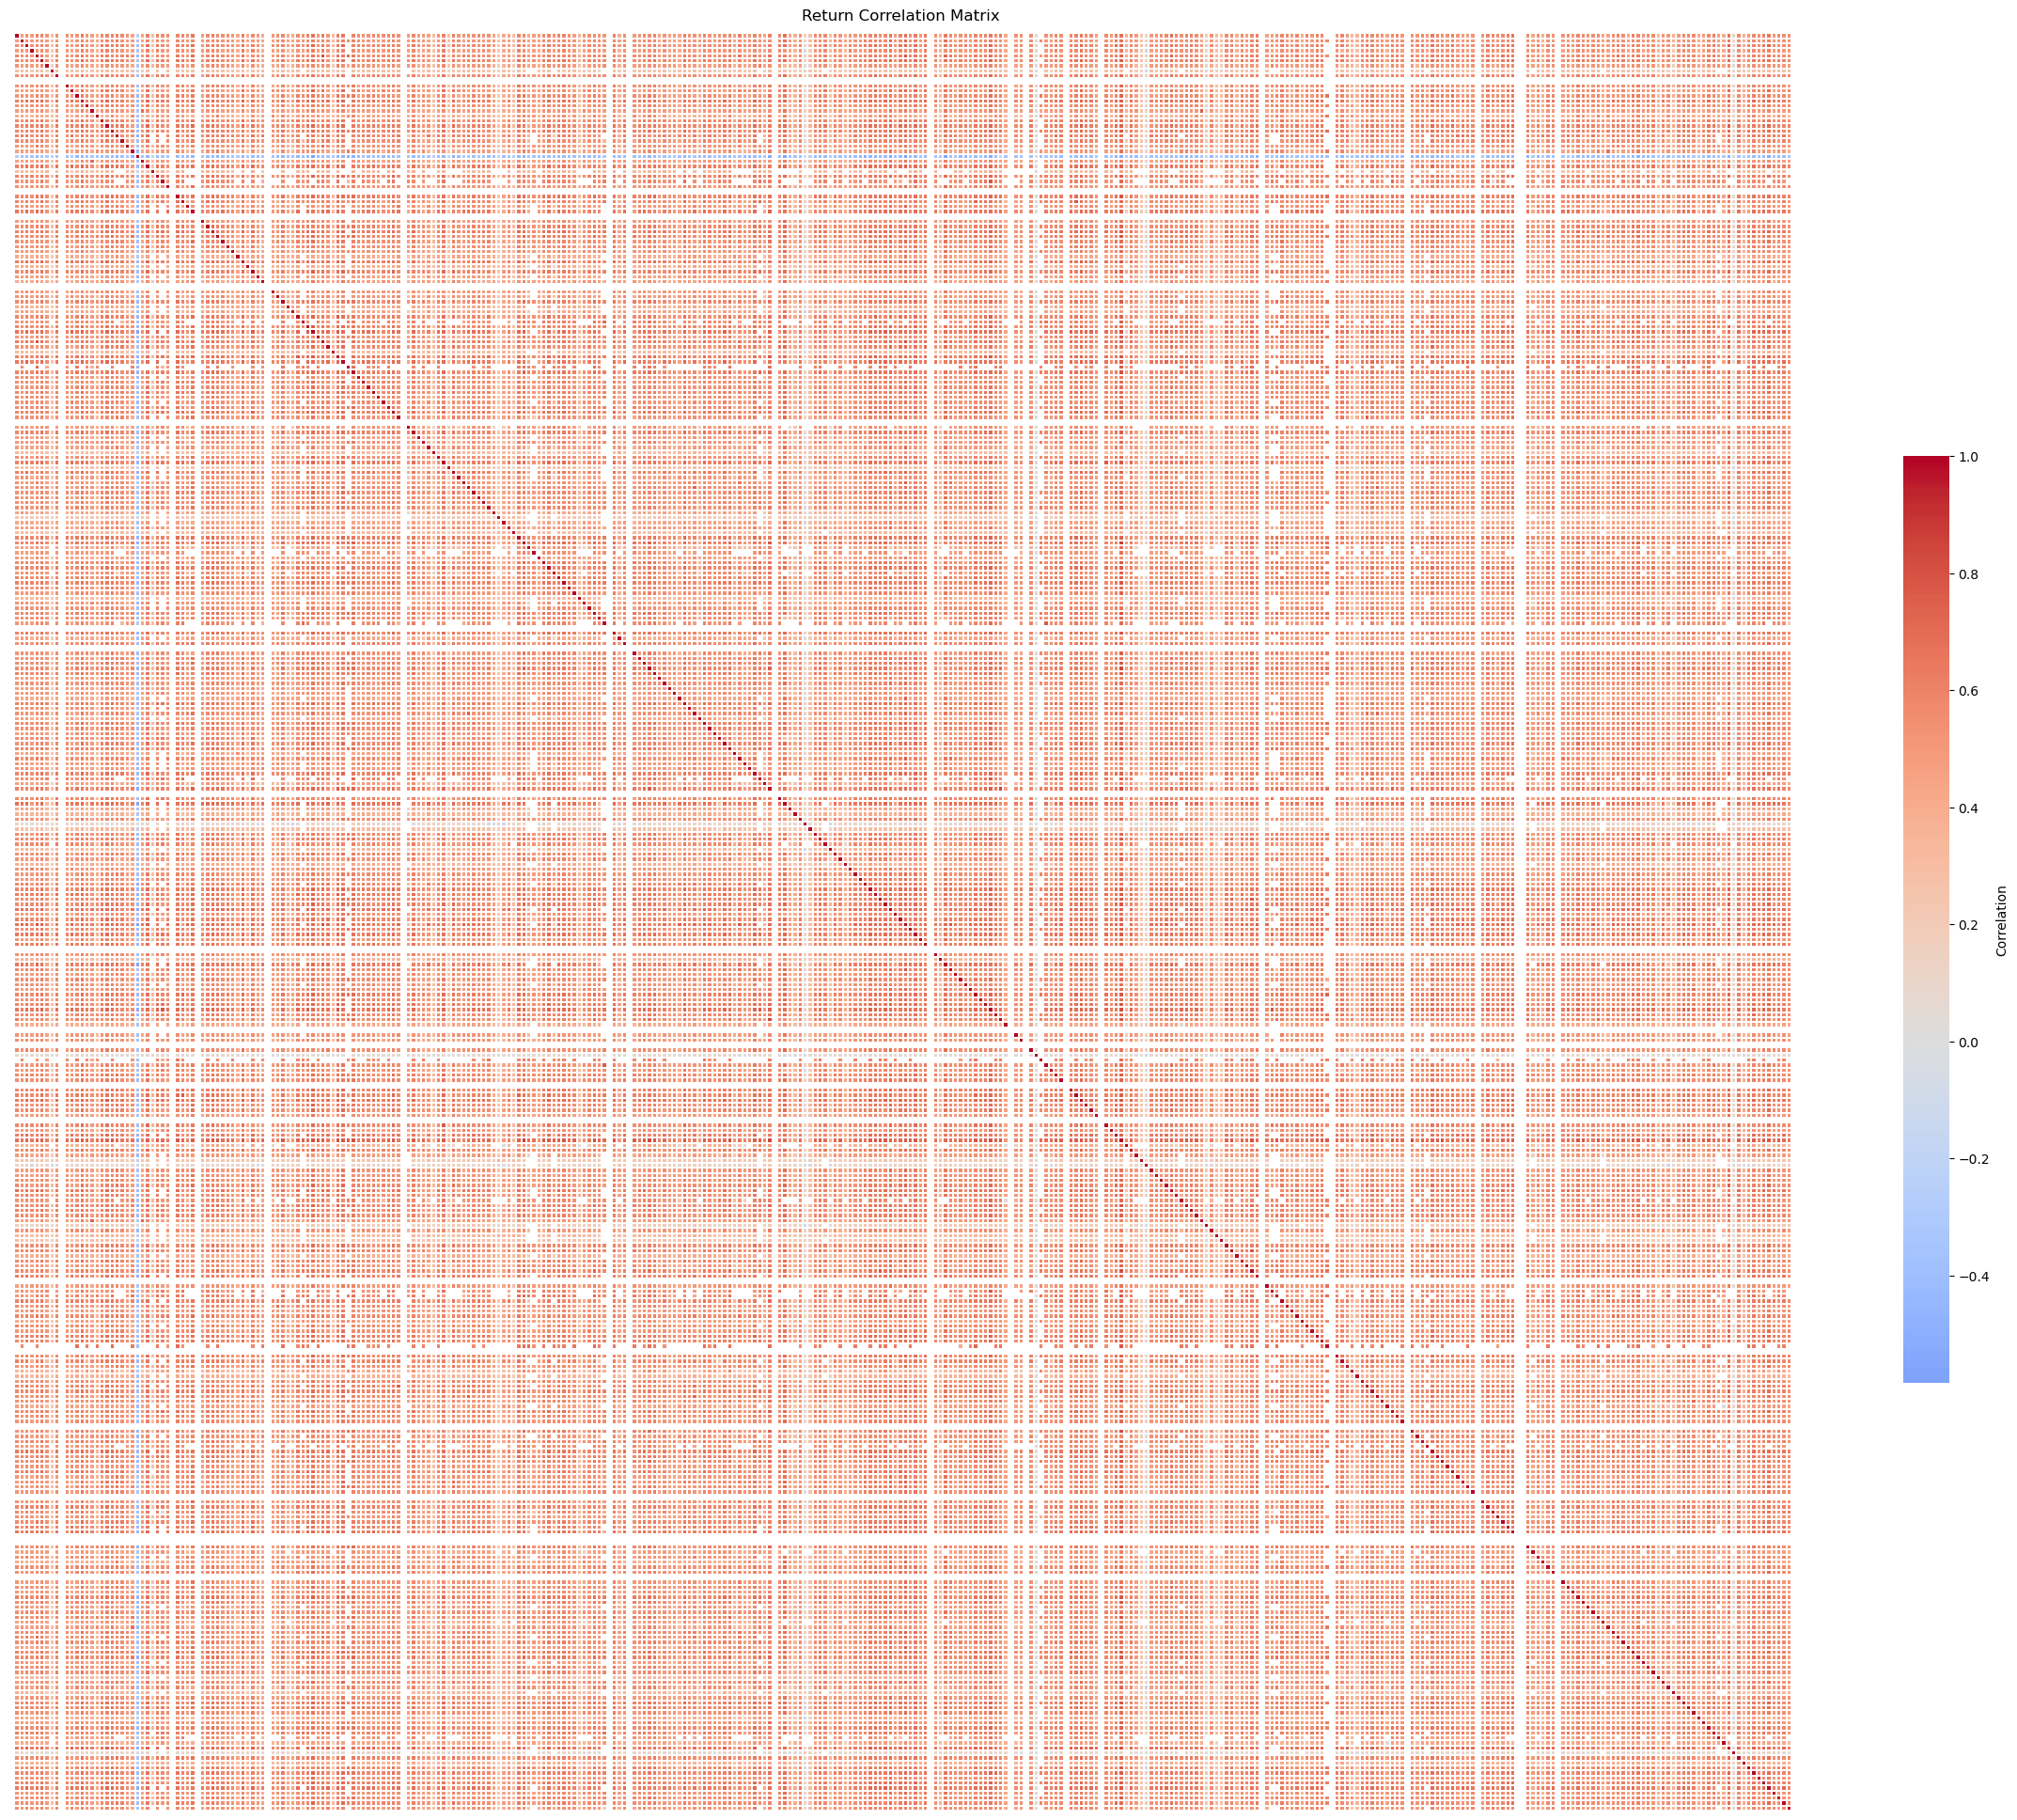

In [10]:
# Read the correlation matrix CSV
corr_matrix = pd.read_csv('return_correlation_matrix.csv', index_col=0)

# Plot the correlation matrix with a fine resolution
plt.figure(figsize=(24, 20))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.01,
    cbar_kws={'shrink': 0.5, 'label': 'Correlation'},
    xticklabels=False,
    yticklabels=False
)
plt.title('Return Correlation Matrix')
plt.tight_layout()
plt.show()